# Project

# Useful things

# Olfaction

**Summary:** In this tutorial, we will implement a something that can change the world.

The detailed documentation of the `OdorArena` class can be found in the [API reference](https://neuromechfly.org/api_ref/arena.html#flygym.mujoco.arena.OdorArena). Its implementation is beyond the scope of this tutorial but can be found [here](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/mujoco/arena/sensory_environment.py).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from tqdm import trange
from gymnasium.utils.env_checker import check_env
from flygym import Fly, Camera
from flygym.arena import FlatTerrain
from flygym.arena import OdorArena
# from flygym.examples.vision_connectome_model.arena import MovingFlyArena
from flygym.examples.obstacle_arena import ObstacleOdorArena
from flygym.examples.turning_controller import HybridTurningNMF

In [2]:
from pathlib import Path

Path("./outputs").mkdir(exist_ok=True)

In [3]:
odor_source = np.array([[5, 0, 0.2]])
peak_odor_intensity = np.array([[1, 0]])
marker_colors = [[255, 127, 14]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])
odor_dimensions = len(peak_odor_intensity[0])

# #for multiple sources
# odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])
# peak_odor_intensity = np.array([[1, 0], [0, 1], [0, 1]])
# marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
# odor_dimensions = len(peak_odor_intensity[0])



In [4]:
# We start by creating a simple arena
flat_terrain_arena = FlatTerrain()

# Then, we add visual and olfactory features on top of it
arena = OdorArena(
    odor_source=odor_source,
    peak_odor_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

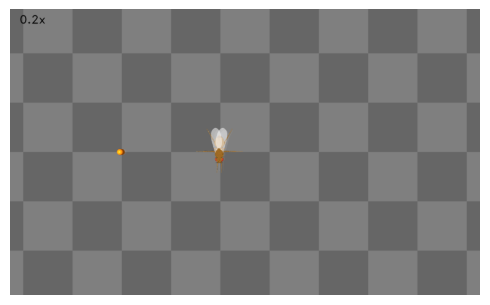

In [5]:
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
    spawn_pos=(0, 0, 0.2),
    spawn_orientation=(0, 0, 0),
    contact_sensor_placements=contact_sensor_placements,
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
)

cam = Camera(
    fly=fly,
    camera_id="birdeye_cam",
    play_speed=0.2,
    window_size=(1000, 608),
)

sim = HybridTurningNMF(
    fly=fly,
    cameras=[cam],
    arena=arena,
    #timestep=1e-4,
)

# for i in range(50):
#     # # # # arena.odor_source[]
#     obs, reward, terminated, truncated, info = sim.step(np.zeros(2))
#     sim.render()

marker = arena.root_element.find("body", "odor_source_marker_0")
sim.physics.bind(marker).mocap_pos[:2] = [-10, 0]
arena.odor_source[0, :2] = [-10, 0]

for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(cam._frames[-1])
ax.axis("off")
fig.savefig("./outputs/olfaction_env.png")

In [6]:
# Simulation parameters
attractive_gain = -500  # Kept for future use or logging
aversive_gain = 80  # Kept for future use or logging
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim.timestep)

speed = 5
curr_time = 0
initial_xpos = -10

x_positions = []
times = []

obs_hist = []
odor_history = []
obs, _ = sim.reset()

I_l_t_0 = 0
I_r_t_0 = 0
HRC_model =[]
p=0

for i in trange(num_decision_steps):
    # Calculate odor intensities
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    # 
    )

    # if p==5:
    I_l_t_1 = attractive_intensities[0]
    I_r_t_1 = attractive_intensities[1]
    HRC_model.append(I_l_t_0*I_r_t_1 - I_l_t_1*I_r_t_0)
    I_l_t_0 = I_l_t_1
    I_r_t_0 = I_r_t_1
    # p=0
    # p+=1

    # Record calculated intensities
    odor_history.append((attractive_intensities, aversive_intensities))

    # Keep the fly stationary
    control_signal = np.zeros((2,))  # No movement control signal

    for j in range(physics_steps_per_decision_step):
        curr_time += sim.timestep
        xpos = initial_xpos + speed * curr_time

        # Record the current time and x position
        times.append(curr_time)
        x_positions.append(xpos)

        marker = arena.root_element.find("body", "odor_source_marker_0")
        sim.physics.bind(marker).mocap_pos[:2] = [xpos, 0]
        arena.odor_source[0, :2] = [xpos, 0]
        
        obs, _, _, _, _ = sim.step(np.array([0.0, 0.0]))
        rendered_img = sim.render()[0]
        if rendered_img is not None:
            im = cv2.putText(
                rendered_img,
                "Hello world", # change this to the text you want
                (100, 50), # position
                cv2.FONT_HERSHEY_SIMPLEX, # font
                1, # font scale
                (0, 0, 0), # color
                2, # thickness
                cv2.LINE_AA, # line type
            )
            cam._frames[-1] = im
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)
    
        # obs, _, _, _, _ = sim.step(control_signal)
        # rendered_img = sim.render()
        # if rendered_img is not None:
        #     pass

    # Check if simulation needs to stop under specific conditions
    if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
        break

# Further processing or analysis can be performed on odor_history


100%|██████████| 100/100 [08:06<00:00,  4.86s/it]


In [7]:
odor_history

[(array([0.04283039, 0.03453149]), array([0., 0.])),
 array([[0.04340036, 0.03443379, 0.03768944, 0.03540389],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 array([[0.04381142, 0.03469079, 0.03821866, 0.03587008],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 array([[0.04325378, 0.03428845, 0.03784939, 0.03552896],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 array([[0.04346207, 0.03442778, 0.03805939, 0.03571668],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 array([[0.04335541, 0.03435446, 0.03796975, 0.03563586],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 array([[0.04342295, 0.03439996, 0.03803935, 0.03569822],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 array([[0.04341577, 0.03439378, 0.03803983, 0.03569823],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
 array([[0.04342

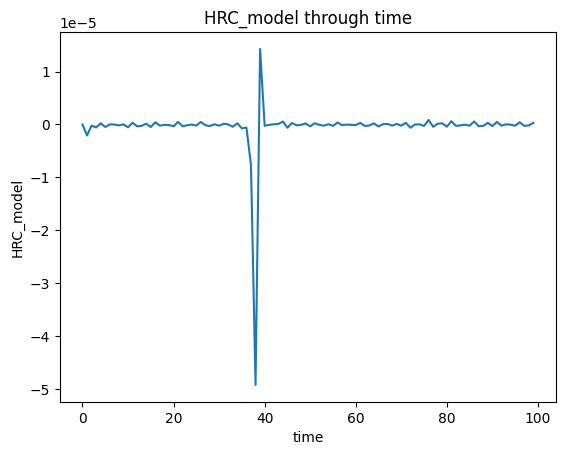

[0.0,
 -2.0704052567021777e-06,
 -2.196185506372298e-07,
 -5.657106456711126e-07,
 2.1034147385532234e-07,
 -4.7263947785093977e-07,
 2.2627825449093517e-08,
 -6.705639369296301e-09,
 -1.7182133616637854e-07,
 2.0584339014339745e-08,
 -5.313937542620641e-07,
 3.378194929580785e-07,
 -3.517203673018311e-07,
 -2.5413646398755874e-07,
 1.4357872226626427e-07,
 -4.800654436149052e-07,
 4.1760071108867987e-07,
 -2.1474174464108584e-07,
 -6.762922472405321e-08,
 -1.1166225406681121e-07,
 -3.463145581120066e-07,
 4.841323699344893e-07,
 -3.445830462369369e-07,
 -1.4175529773207025e-07,
 -2.7478097489432377e-08,
 -2.0122653150624753e-07,
 4.597903788825311e-07,
 -1.4087862012417476e-07,
 -2.95499107849e-07,
 5.014372049159076e-08,
 -2.4138844755515476e-07,
 1.40629259723574e-07,
 7.858762523333881e-09,
 -4.3337213385865464e-07,
 2.231549617243752e-07,
 -7.445444518247753e-07,
 -5.820810782340268e-07,
 -7.700437263344698e-06,
 -4.926334924724909e-05,
 1.4291694536322595e-05,
 -2.583044242583134

In [8]:

#show graph HRC_model through time
plt.plot(HRC_model)
plt.xlabel('time')
plt.ylabel('HRC_model')
plt.title('HRC_model through time')
plt.savefig("./outputs/HRC2.png")
plt.show()

HRC_model


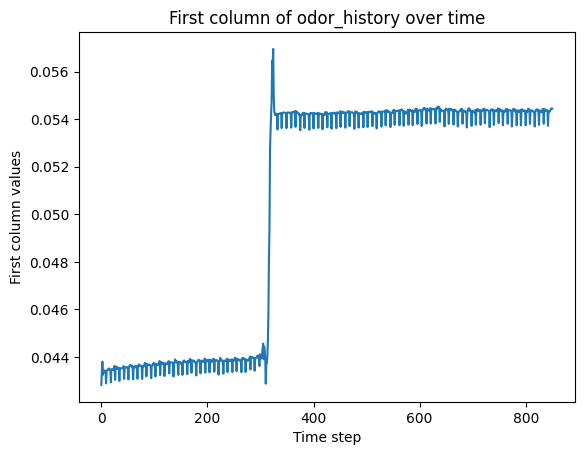

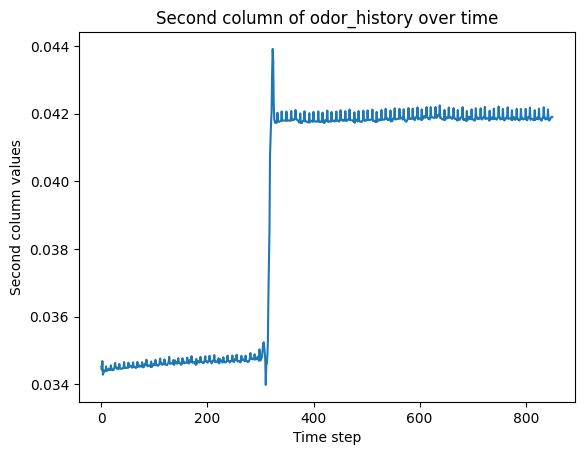

In [9]:
# Extract the first column from odor_history
first_column = [entry[0][0] for entry in odor_history]

# Plot the first column
plt.plot(first_column)
plt.xlabel('Time step')
plt.ylabel('First column values')
plt.title('First column of odor_history over time')
plt.show()

# Extract the second column from odor_history
second_column = [entry[0][1] for entry in odor_history]

# Plot the second column
plt.plot(second_column)
plt.xlabel('Time step')
plt.ylabel('Second column values')
plt.title('Second column of odor_history over time')
plt.show()

We can visualize the Odor movement:

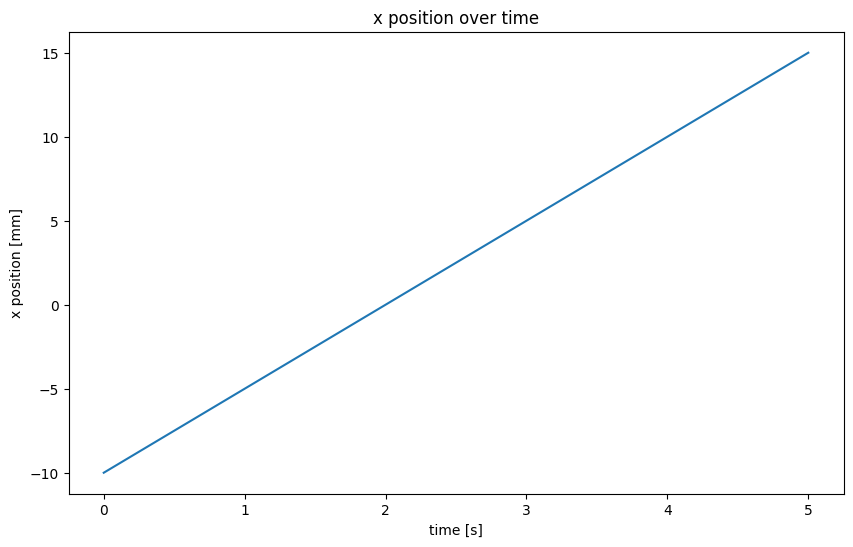

In [10]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(times, x_positions)
plt.xlabel('time [s]')
plt.ylabel('x position [mm]')
plt.title('x position over time')
plt.show()

In [11]:
import os
if not os.path.exists('outputs'):
    os.makedirs('outputs')
cam.save_video("./outputs/odor_moving.mp4")

====================================================================================================

## Odor arena

To demonstrate odor sensing, let's create an environment with one attractive odor source and two aversive odor sources. The dimension of this odor space is 2 (attractive, aversive) despite the number of odor sources being 3. The odor sources share a peak intensity of 1. We will color the attractive odor source orange and the aversive odor sources blue.

In [12]:
import numpy as np

# random state seed for reproducibility
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[1, 0], [0, 1], [0, 1]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

Let's create the arena using these parameters. The detailed documentation of the `OdorArena` class can be found in the [API reference](https://neuromechfly.org/api_ref/arena.html#flygym.mujoco.arena.OdorArena). Its implementation is beyond the scope of this tutorial but can be found [here](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/mujoco/arena/sensory_environment.py).

In [13]:
from flygym.arena import OdorArena

arena = OdorArena(
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

TypeError: OdorArena.__init__() got an unexpected keyword argument 'peak_intensity'

Let’s place our fly in the arena. As before, we will run a few iterations to allow it to stand on the ground in a stable manner.

Note that we will be using the `HybridTurningNMF` as the turning controller. This class serves as an enhanced version of the `TurningNMF` in the previous exercises, utilizing sensory feedback to prevent the fly from stumbling. For further details, refer to https://neuromechfly.org/tutorials/hybrid_controller.html and https://neuromechfly.org/tutorials/turning.html.

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from flygym import Parameters
from flygym.examples.turning_controller import HybridTurningNMF


Path("./outputs").mkdir(exist_ok=True)


contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
)
for i in range(500):
    
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
fig.savefig("./outputs/olfaction_env.png")

NameError: name 'arena' is not defined

We can visualize the fly trajectory:

In [ ]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 25)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig("./outputs/odor_taxis_trajectory.png")

NameError: name 'obs_hist' is not defined

We can also generate the video:

In [ ]:
sim.save_video("./outputs/odor_taxis.mp4")

from IPython import display

display.Video("./outputs/odor_taxis.mp4")

NameError: name 'sim' is not defined